In [253]:
import seaborn as sns
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import heartpy as hp
import scipy
from scipy import signal, stats, spatial, optimize, interpolate
from scipy.signal import butter, lfilter, resample, lfilter, medfilt, correlate
from statistics import mean
from datetime import datetime, timezone, timedelta
import pytz
import os

def opencsv(name):
    with open(name) as fp:
        skip = next(filter(
            lambda x: x[1].startswith('timestamp'),
            enumerate(fp)
        ))[0]
    df = pd.read_csv(name, skiprows=skip)
    df.drop(df.tail(4).index,
            inplace = True)
    df['timestamp']=df['timestamp'].astype(float).astype(int)
    return df

def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = signal.butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, fs, cutoff, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = signal.filtfilt(b, a, data)
    return y

def peakfind(x):
    peaks, _ = scipy.signal.find_peaks(x, distance=40, prominence=200)
    return peaks

## Helper Methods

In [254]:
def convert_to_unix(timestamp_str, timezone_str='Asia/Singapore'):
    # Define the format of the input timestamp
    timestamp_format = "%H:%M:%S %b %d %Y"

    # Parse the input timestamp string
    timestamp = datetime.strptime(timestamp_str, timestamp_format)

    # Set the timezone for the input timestamp
    input_timezone = pytz.timezone(timezone_str)
    timestamp = input_timezone.localize(timestamp)

    # Convert the timestamp to the Asia/Singapore timezone
    singapore_timezone = pytz.timezone("Asia/Singapore")
    timestamp_singapore = timestamp.astimezone(singapore_timezone)

    # Convert the timestamp to UNIX timestamp
    unix_timestamp = int(timestamp_singapore.timestamp())

    return unix_timestamp

def convert_to_unix_v2(timestamp_str, timezone_str='Asia/Singapore'):
    # Define the format of the input timestamp
    timestamp_format = "%Y/%m/%d %H:%M"

    # Parse the input timestamp string
    timestamp = datetime.strptime(timestamp_str, timestamp_format)

    # Set the timezone for the input timestamp
    input_timezone = pytz.timezone(timezone_str)
    timestamp = input_timezone.localize(timestamp)

    # Convert the timestamp to the Asia/Singapore timezone
    singapore_timezone = pytz.timezone("Asia/Singapore")
    timestamp_singapore = timestamp.astimezone(singapore_timezone)

    # Convert the timestamp to UNIX timestamp
    unix_timestamp = int(timestamp_singapore.timestamp())

    return unix_timestamp

def peakfind_ecg(x, distance=40, prominence=0.3):
    peaks, _ = scipy.signal.find_peaks(x, distance=distance, prominence=prominence)
    return peaks

def peakfind_ppg(x, distance=40, prominence=200):
    peaks, _ = scipy.signal.find_peaks(x, distance=distance, prominence=prominence)
    return peaks

def align_in_ref(p_in, p_ref, prom_ref=200, prom_in=200):
    peaks_in = peakfind_ppg(p_in, prominence=prom_in)
    peaks_ref = peakfind_ppg(p_ref, prominence=prom_ref)
    
    anchor = peaks_in[1]
    return min([pd - anchor for pd in peaks_ref], key=abs)

## Extracting Windows

In [255]:
# SET THE SUBJECT'S ID HERE

s_id = 'self2'

In [256]:
df_ppg_in = opencsv('wrist_' + s_id +'.csv')
df_ppg_ref = opencsv('finger_' + s_id +'.csv')
df_pressure = pd.read_csv('pres_' + s_id +'.csv')
df_ecg = pd.read_csv('ecg_' + s_id + '.csv')
df_spo2 = pd.read_csv('spo2_' + s_id + '.csv')
df_bp = pd.read_csv('bp_' + s_id + '.csv')

### Temporary, fix time issue
newtime = []
t = df_pressure['time'].values[0]

newtime.append(t)

for i in range(1, len(df_pressure)):
    t = t + 12 + (i % 2)
    newtime.append(t)
    
df_pressure['time'] = newtime
###


start = min(df_pressure['time'])

df_ppg_in['timestamp']-=start
df_ppg_in['timestamp']/=1000
df_ppg_ref['timestamp']-=start
df_ppg_ref['timestamp']/=1000

df_ppg_in['PPG_LPF_10Hz'] = butter_lowpass_filter(df_ppg_in['LEDC1'], 128, 10)
df_ppg_ref['PPG_LPF_10Hz'] = butter_lowpass_filter(df_ppg_ref['LEDC1'], 128, 10)

df_pressure['time']-=start
df_pressure['time']/=1000
df_pressure['reading'] = butter_lowpass_filter(df_pressure['reading'], 80, 8)

df_ecg['time']/=1000000
df_ecg['time']-=start
df_ecg['time']/=1000

df_ppg_in = df_ppg_in[df_ppg_in['timestamp'] >=0].copy()
df_ppg_ref = df_ppg_ref[df_ppg_ref['timestamp'] >=0].copy()

/var/folders/db/jd5sxcv14dx66ylxdf8scbsc0000gn/T/ipykernel_49368/1674647097.py:21: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(name, skiprows=skip)
/var/folders/db/jd5sxcv14dx66ylxdf8scbsc0000gn/T/ipykernel_49368/1674647097.py:21: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(name, skiprows=skip)


In [257]:
df_spo2['Timestamp'] = df_spo2['Time'].apply(lambda x: convert_to_unix(x))
df_bp['Timestamp'] = df_bp['Measurement Date'].apply(lambda x: convert_to_unix_v2(x))

df_spo2['Timestamp'] -= start//1000
df_bp['Timestamp'] -= start

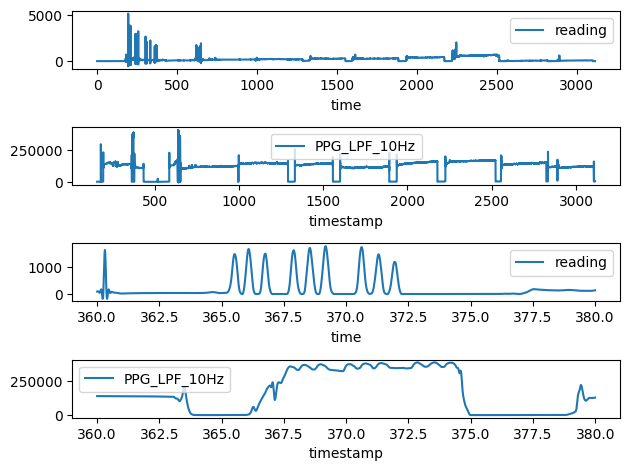

In [258]:
# Find out where the sync spikes are

fig, axes = plt.subplots(4, 1)

df_pressure.plot(x='time', y='reading', ax=axes[0])
df_ppg_in.plot(x='timestamp', y='PPG_LPF_10Hz', ax=axes[1])

# Limit the plot to the sync spikes
# Adjust these params
limit_view_start = 360
limit_view_end = 380

df_pressure[df_pressure['time'].between(limit_view_start, limit_view_end)].plot(x='time', y='reading', ax=axes[2])
df_ppg_in[df_ppg_in['timestamp'].between(limit_view_start, limit_view_end)].plot(x='timestamp', y='PPG_LPF_10Hz', ax=axes[3])
plt.tight_layout()
plt.show()

369.175 371.41
-2.2350000000000136


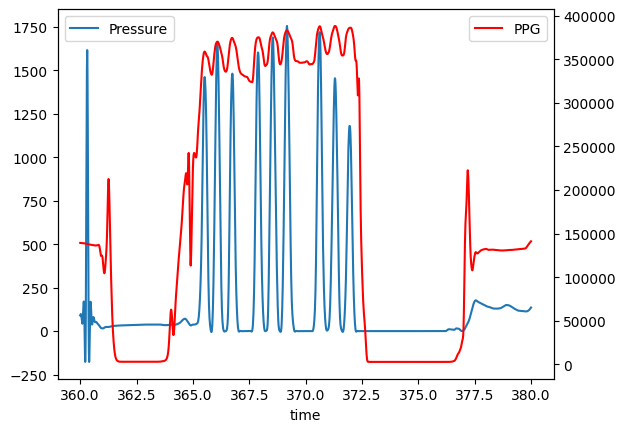

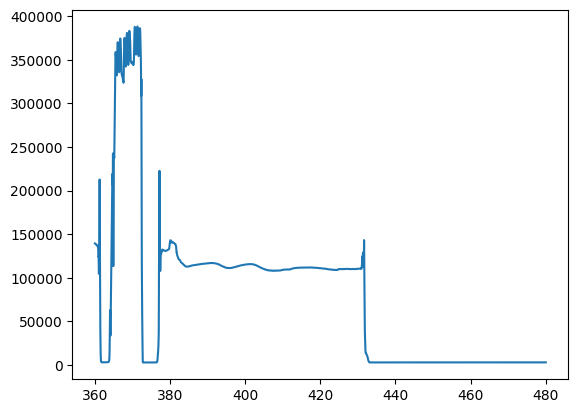

In [259]:
# Synchronising PPG in and pressure
pres_s = 367
pres_e = 370
ppg_s = 370
ppg_e = 372

pres_max = df_pressure[df_pressure['time'].between(pres_s, pres_e)]['reading'].idxmax()
ppg_max = df_ppg_in[df_ppg_in['timestamp'].between(ppg_s, ppg_e)]['PPG_LPF_10Hz'].idxmax()

print(df_pressure.loc[pres_max]['time'], df_ppg_in.loc[ppg_max]['timestamp'])
correction = df_pressure.loc[pres_max]['time'] - df_ppg_in.loc[ppg_max]['timestamp']
print(correction)
df_ppg_in['timestamp'] += correction
df_ppg_ref['timestamp'] += correction

# Sync to pressure timestamp

ax = df_pressure[df_pressure['time'].between(limit_view_start, limit_view_end)].plot(x='time', y='reading')
h,l = ax.get_legend_handles_labels()
ax.legend(h[:2], ['Pressure'], loc=2)
ax = ax.twinx()
df_ppg_in[df_ppg_in['timestamp'].between(limit_view_start, limit_view_end)].plot(ax=ax, x='timestamp', y='PPG_LPF_10Hz', color="r")
plt.legend(['PPG'])
plt.show()

df_ppg_look_4_start = df_ppg_in[df_ppg_in['timestamp'].between(limit_view_start, limit_view_start + 120)]
plt.plot(df_ppg_look_4_start['timestamp'], df_ppg_look_4_start['PPG_LPF_10Hz'])
plt.show()

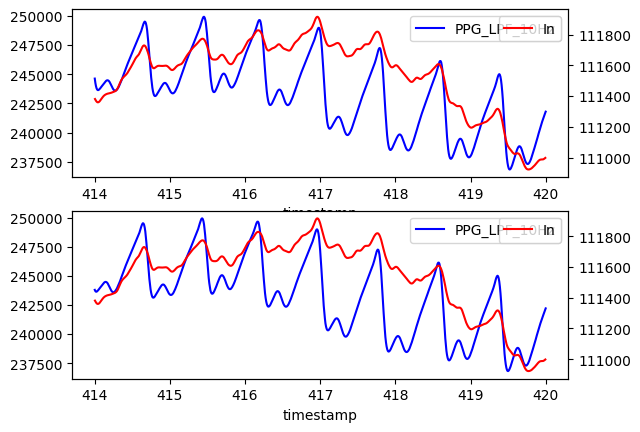

In [260]:
# Sync Reference PPG to Input PPG
ppg_ir_s = 414
ppg_ir_e = 420

fig, axes = plt.subplots(2, 1)

df_ppg_ref[df_ppg_ref['timestamp'].between(ppg_ir_s, ppg_ir_e)].plot(ax=axes[0], x='timestamp', y='PPG_LPF_10Hz', color="b")
h,l = ax.get_legend_handles_labels()
ax.legend(h[:2], ['Ref'], loc=2)
axes[0] = axes[0].twinx()
df_ppg_in[df_ppg_in['timestamp'].between(ppg_ir_s, ppg_ir_e)].plot(ax=axes[0], x='timestamp', y='PPG_LPF_10Hz', color="r")
plt.legend(['In', 'Ref'])

offset = align_in_ref(df_ppg_in[df_ppg_in['timestamp'].between(ppg_ir_s, ppg_ir_e)]['PPG_LPF_10Hz'], \
            df_ppg_ref[df_ppg_ref['timestamp'].between(ppg_ir_s, ppg_ir_e)]['PPG_LPF_10Hz'], \
            prom_in=50)

df_ppg_ref['timestamp'] -= offset * (1/128)

df_ppg_ref[df_ppg_ref['timestamp'].between(ppg_ir_s, ppg_ir_e)].plot(ax=axes[1], x='timestamp', y='PPG_LPF_10Hz', color="b")
h,l = ax.get_legend_handles_labels()
ax.legend(h[:2], ['Ref'], loc=2)
axes[1] = axes[1].twinx()
df_ppg_in[df_ppg_in['timestamp'].between(ppg_ir_s, ppg_ir_e)].plot(ax=axes[1], x='timestamp', y='PPG_LPF_10Hz', color="r")
plt.legend(['In', 'Ref'])
plt.show()

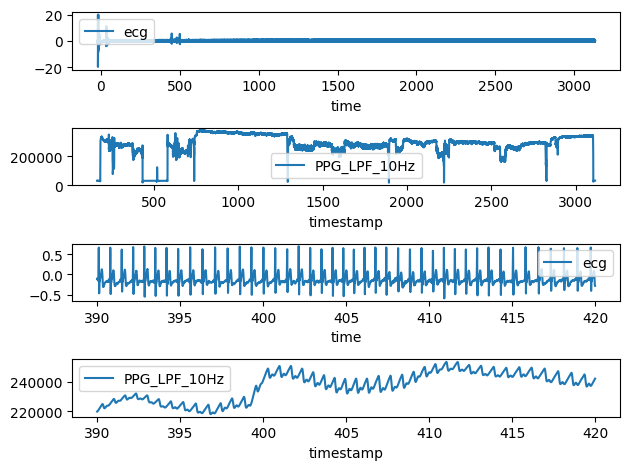

In [261]:
# Sync ECG to PPG, which is already synced to pressure

# Find out where the sync spikes are

fig, axes = plt.subplots(4, 1)

df_ecg.plot(x='time', y='ecg', ax=axes[0])
df_ppg_ref.plot(x='timestamp', y='PPG_LPF_10Hz', ax=axes[1])

# Limit the plot to the sync spikes
# Adjust these params
limit_view_start = 390
limit_view_end = 420

df_ecg[df_ecg['time'].between(limit_view_start, limit_view_end)].plot(x='time', y='ecg', ax=axes[2])
df_ppg_ref[df_ppg_ref['timestamp'].between(limit_view_start, limit_view_end)].plot(x='timestamp', y='PPG_LPF_10Hz', ax=axes[3])
plt.tight_layout()
plt.show()

-2


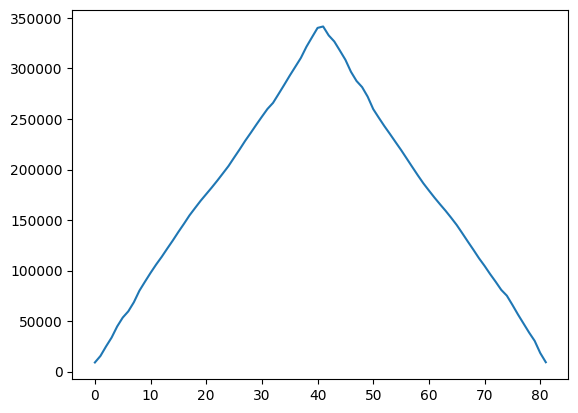

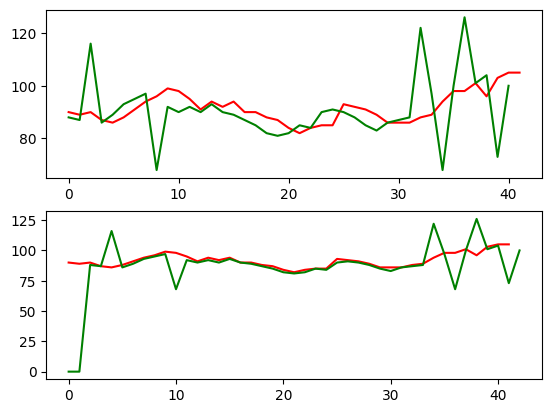

In [262]:
ecg_section = df_ecg[df_ecg['time'].between(limit_view_start, limit_view_end)]
ppg_section = df_ppg_ref[df_ppg_ref['timestamp'].between(limit_view_start, limit_view_end)]

peaks_ecg = peakfind_ecg(ecg_section['ecg'])
peaks_ppg = peakfind_ppg(ppg_section['PPG_LPF_10Hz'] * -1)


dists_ecg = []
for i in range(1, len(peaks_ecg)):
    dists_ecg.append(peaks_ecg[i] - peaks_ecg[i-1])

dists_ppg = []
for i in range(1, len(peaks_ppg)):
    dists_ppg.append(peaks_ppg[i] - peaks_ppg[i-1])
    
to_shift = correlate(dists_ecg, dists_ppg).argmax() - len(dists_ecg) - 1
print(to_shift)
plt.plot(correlate(dists_ecg, dists_ppg))
plt.show()

# If negative, pad ppg, else pad ecg

plt.subplot(2, 1, 1)
plt.plot(dists_ecg, color='r')
plt.plot(dists_ppg, color='g')

plt.subplot(2, 1, 2)
plt.plot(dists_ecg, color='r')
plt.plot([0, 0] + dists_ppg, color='g')

plt.show()

1.0300556640625018


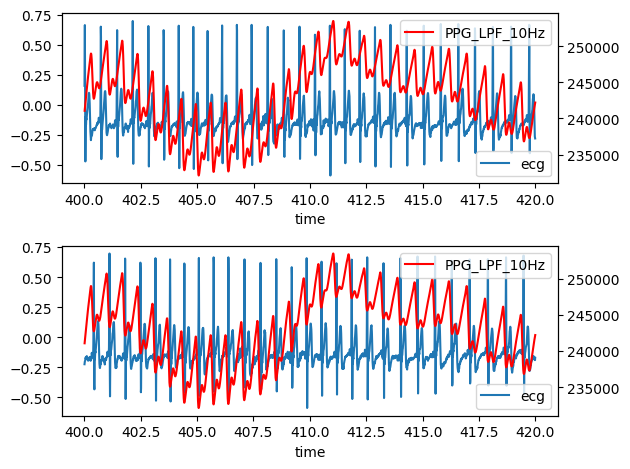

In [263]:
if to_shift > 0:
    time_shift = ppg_section['timestamp'].values[peaks_ppg[0]] - ecg_section['time'].values[peaks_ecg[to_shift]]
elif to_shift < 0:
    time_shift = ecg_section['time'].values[peaks_ecg[to_shift * -1]] - ppg_section['timestamp'].values[peaks_ppg[0]]

print(time_shift)

limit_view_start = 400
limit_view_end = 420

fig, axes = plt.subplots(2, 1)

df_ecg[df_ecg['time'].between(limit_view_start, limit_view_end)].plot(x='time', y='ecg', ax=axes[0])
axes[0] = axes[0].twinx()
df_ppg_ref[df_ppg_ref['timestamp'].between(limit_view_start, limit_view_end)].plot(x='timestamp', y='PPG_LPF_10Hz', ax=axes[0], color='r')

df_ecg['time'] -= time_shift

df_ecg[df_ecg['time'].between(limit_view_start, limit_view_end)].plot(x='time', y='ecg', ax=axes[1])
axes[1] = axes[1].twinx()
df_ppg_ref[df_ppg_ref['timestamp'].between(limit_view_start, limit_view_end)].plot(x='timestamp', y='PPG_LPF_10Hz', ax=axes[1], color='r')

plt.tight_layout()
plt.show()

In [264]:
# Find the start of content
start = 380

In [265]:
end = min(max(df_ppg_in['timestamp']), max(df_ppg_ref['timestamp']), max(df_pressure['time']))

df_ppg_in = df_ppg_in[df_ppg_in['timestamp'].between(start, end)].copy()
df_ppg_ref = df_ppg_ref[df_ppg_ref['timestamp'].between(start, end)].copy()
df_pressure = df_pressure[df_pressure['time'].between(start, end)].copy()
df_ecg = df_ecg[df_ecg['time'].between(start, end)].copy()
df_spo2 = df_spo2[df_spo2['Timestamp'].between(start, end)].copy()

<Axes: xlabel='Time'>

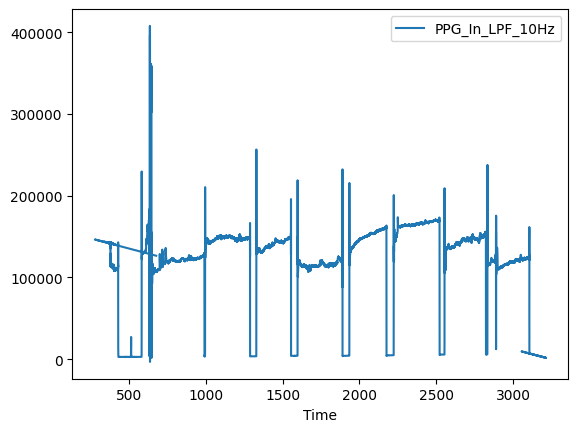

In [266]:
ln = int(len(df_ppg_in)*100/128)

time = signal.resample(df_ppg_in['timestamp'], ln)
ppg_in = signal.resample(df_ppg_in['PPG_LPF_10Hz'], ln)
ppg_ref = signal.resample(df_ppg_ref['PPG_LPF_10Hz'], ln)
pressure = signal.resample(df_pressure['reading'], ln)
ecg = signal.resample(df_ecg['ecg'], ln)
spo2 = signal.resample(df_spo2['Oxygen Level'], ln)

df_final = pd.DataFrame(data={\
                              'Time': time,\
                              'PPG_In_LPF_10Hz': ppg_in,\
                              'PPG_Ref_LPF_10Hz': ppg_ref,\
                              'Pressure_In': pressure,\
                              'ECG': ecg,\
                              'SpO2': spo2
                             })

df_final.plot(x='Time', y='PPG_In_LPF_10Hz')
    

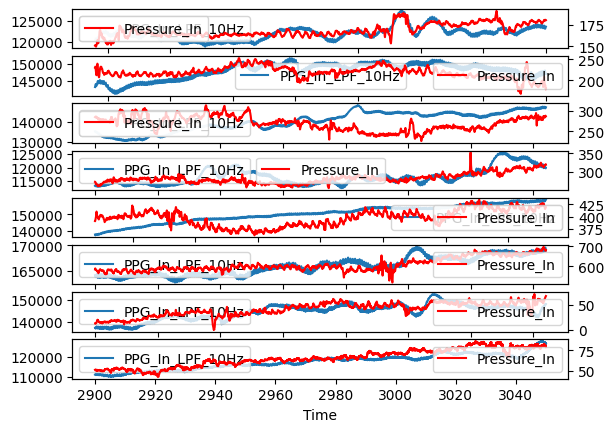

In [267]:
idxs = [[770, 950], [1020, 1200], [1350, 1530], [1700, 1880], \
        [1960, 2140], [2300, 2480], [2600, 2780], [2900, 3050]]

i=0
fig, axes = plt.subplots(len(idxs), 1)
for idx in idxs:
    a = idx[0]
    b = idx[1]
    small = df_final[df_final['Time'].between(a, b)].copy()
    
    small['BP_Sys'] = df_bp['SYS(mmHg)'].values[i]
    small['BP_Dia'] = df_bp['DIA(mmHg)'].values[i]
    
    small.plot(ax=axes[i], x='Time', y='PPG_In_LPF_10Hz')
    axes[i]=axes[i].twinx()
    small.plot(ax=axes[i], x='Time', y='Pressure_In', color='r')
    
    small[['Time','PPG_In_LPF_10Hz', 'PPG_Ref_LPF_10Hz', 'Pressure_In', 'ECG', 'BP_Sys', 'BP_Dia', 'SpO2']].to_csv(str(i) + '_raw_' + s_id + '.csv')
    
    i+=1

## Removing the AC Component

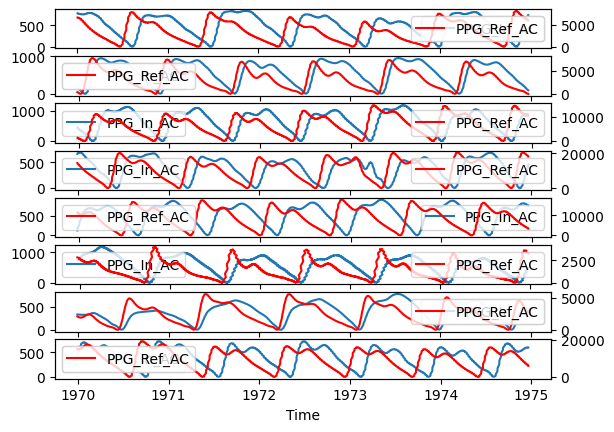

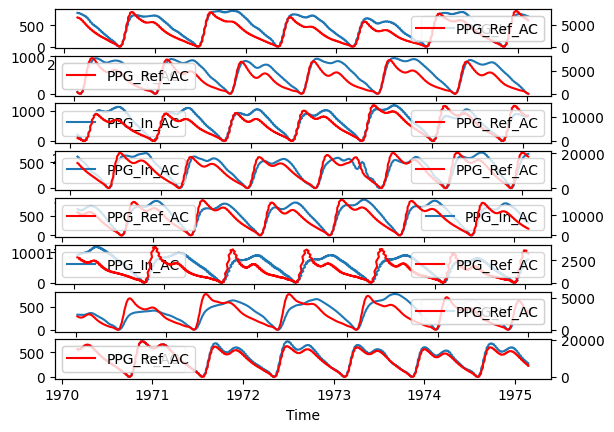

In [268]:
all_files = os.listdir("./")

csv_files = [file for file in all_files if 'raw' in file and file.endswith('.csv')]

i=0
_, axes = plt.subplots(len(csv_files), 1)
_, axes2 = plt.subplots(len(csv_files), 1)

for csv_file in csv_files:
    # Removing the AC Component
    
    df = pd.read_csv(csv_file)
    peaks = peakfind(df['PPG_In_LPF_10Hz'].values)
    line = interpolate.CubicSpline(df['Time'].values[peaks], df['PPG_In_LPF_10Hz'].values[peaks])
    df['PPG_In_AC'] = (df['PPG_In_LPF_10Hz'] - line(df['Time'].values))*-1

    peaks = peakfind(df['PPG_Ref_LPF_10Hz'].values)
    line = interpolate.CubicSpline(df['Time'].values[peaks], df['PPG_Ref_LPF_10Hz'].values[peaks])
    df['PPG_Ref_AC'] = (df['PPG_Ref_LPF_10Hz'] - line(df['Time'].values))*-1
    
    # Synchronise Ref to In
    local_offset = align_in_ref(-df['PPG_In_AC'], -df['PPG_Ref_AC'])
    
    # Visualise
    df[1000:1500].plot(ax=axes[i], x='Time', y='PPG_In_AC')
    axes[i]=axes[i].twinx()
    df[1000:1500].plot(ax=axes[i], x='Time', y='PPG_Ref_AC', color='r')
    
    df['PPG_Ref_AC'] = df['PPG_Ref_AC'].shift(-local_offset)
    df = df.dropna()
    
    # Visualise
    df[1000:1500].plot(ax=axes2[i], x='Time', y='PPG_In_AC')
    axes2[i]=axes2[i].twinx()
    df[1000:1500].plot(ax=axes2[i], x='Time', y='PPG_Ref_AC', color='r')
    
    
    df.to_csv(str(i) + '_preprocessed_' + s_id + '.csv')
    i+=1

## Final Visualisation

In [ ]:
csv_files = [file for file in all_files if 'preprocessed' in file and file.endswith('.csv')]

i=0

for csv_file in csv_files:
    df = pd.read_csv(csv_file)[2000:3000]
    
    plt.plot(df['PPG_In_AC'], color='r')
    plt.plot(df['PPG_Ref_AC'], color='g')
    plt.plot(df['ECG']*1000, color='blue')
    
    plt.plot(df['BP_Sys']*50, '--', color='black')
    plt.plot(df['BP_Dia']*50, '--', color='black')
    
    plt.plot(df['SpO2']*50, '--', color='purple')
    
    plt.plot(df['Pressure']*500, color='orange')
    
    break